In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
def norm_trace(seis):
    data_out = np.zeros(np.shape(seis))
    for k in range(np.size(seis,axis=1)):
        data_out[:,k] = seis[:,k]/np.max(np.abs(seis[:,k]))
    seis=data_out
    return seis
def envelope(xr):
    for i in range(np.size(xr,axis=1)):
        hx = fftpack.hilbert(xr[:,i])
        xr[:,i] = np.sqrt(np.power(xr[:,i],2) + np.power(hx,2))
    return xr
def imagesc(damp,alpha=1,cmin=1,cmax=1):
    if cmin == cmax:
        cmin=np.min(damp)
        cmax=np.max(damp)
    fig = plt.figure(facecolor=[0, 32/255, 96/255],figsize=(12,6))
    plt.pcolormesh(damp, vmin=cmin*alpha, vmax=cmax*alpha,cmap= 'jet')
    ax = plt.gca() 
    ax.invert_yaxis() 
    plt.tick_params(axis='x',colors='w')
    plt.tick_params(axis='y',colors='w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
#     plt.xlabel("step",fontsize=20)
#     plt.ylabel("rate",fontsize=20)
    cb=plt.colorbar(pad=0.03)
    cb.ax.tick_params(colors='w',labelsize=18)
    cb.ax.spines['right'].set_color('w')
    matplotlib.cm.get_cmap('jet')
def extend_wave(s,nt):
    ng = np.size(s,axis=1)
    if np.size(s[:,0])<nt:
        ss=np.zeros((nt,ng))
        for i in range(ng):
            xr=np.zeros((nt))
            xr[0:np.size(s[:,0])]=s[:,i]
            ss[:,i]=xr
    return ss
def pad(p0, nbc, pad_top):
    p=torch.cat((p0[:,0].reshape(-1,1).repeat(1,nbc),p0,p0[:,-1].reshape(-1,1).repeat(1,nbc)),dim=1)
    p=torch.cat((p[0,:].reshape(1,-1).repeat(pad_top,1),p,p[-1,:].reshape(1,-1).repeat(nbc,1)),dim=0)
    return p
import scipy.io as sio
import torch
from torch.utils.data import DataLoader
import time

In [2]:
import torch.nn.functional as F
def staggeredfd_py_cuda(
    inputs,
    temp,
    ca,       
    cl,       
    cm,       
    cm1,        
    b,      
    b1,      
    s):
    nt = int(inputs[0])
    nzbc = int(inputs[1])
    nxbc = int(inputs[2])
    dtx = float(inputs[3])
    ng = int(inputs[4])
    sz = int(inputs[5]);sz = sz - 1;
    sx = int(inputs[6]);sx = sx - 1;
    gz = int(inputs[7]);gz = gz - 1;
    gx = int(inputs[8]);gx = gx - 1;
    dg = int(inputs[9])
    source_type_num = int(inputs[10])
    fd_order_num = int(inputs[11])
    number_elements = nt*ng
    length_geophone = ng*dg
    nt_interval = int(inputs[12])
    nz = int(inputs[13])
    nx = int(inputs[14])
    format_num = int(inputs[15])
    nbc = (nxbc-nx)/2
    num_nt_record = nt//nt_interval
    wavefield_elements = num_nt_record*nx*nz


    #   Input variables from python numpy: temp ca cl cm b s
    # libtorch Initialising input variables: uu, ww, xx, xz, zz
    uu = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    ww = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    xx = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    xz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    zz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    #  libtorch Initialising input variables: fux, fuz, bwx, bwz
    fux = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    fuz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    bwx = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    bwz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    #  libtorch Initialising output variables: seismo_w, seismo_u       
    seismo_w = torch.zeros((nt,ng), dtype=torch.float32, device=torch.device('cuda', 0))
    seismo_u = torch.zeros((nt,ng), dtype=torch.float32, device=torch.device('cuda', 0))

    wavefield_gradient_fux = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))
    wavefield_gradient_fuz = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))
    wavefield_gradient_bwx = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))
    wavefield_gradient_bwz = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))

    #  libtorch zero_vector for free surface zz
    zero_vector = torch.zeros((1,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    geophone_vector = torch.zeros((1,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))

    if fd_order_num==22 :
        k = nzbc-2; i = nxbc-2; pad_top = 1;
    elif fd_order_num==24 :
        k = nzbc-4; i = nxbc-4; pad_top = 2;
    elif fd_order_num==26 :
        k = nzbc-6; i = nxbc-6; pad_top = 3;
    elif fd_order_num==28 :
        k = nzbc-8; i = nxbc-8; pad_top = 4;
    S41 = 1.1250;S42 = -0.0416666667;S61 = 1.17187;S62 = -6.51042E-2;S63 = 4.68750E-3;S81 = 1.19629;S82 = -7.97526E-2;S83 = 9.57031E-3;S84 = -6.97545E-4;

    for it in range(nt) :
        if  fd_order_num == 22 :
            uu = F.pad((temp[1:1+k, 1:1+i]*(uu[1:1+k, 1:1+i]) + b[1:1+k, 1:1+i]*(  \
                    xx[1:1+k, 1+1:1+1+i] - xx[1:1+k, 1:1+i] + xz[1:1+k, 1:1+i] - xz[1-1:1-1+k, 1:1+i])), [1, 1, 1, 1])   
            ww = F.pad((temp[1:1+k, 1:1+i]*(ww[1:1+k, 1:1+i]) + b1[1:1+k, 1:1+i]*(  \
                    xz[1:1+k, 1:1+i] - xz[1:1+k, 1-1:1-1+i] + zz[1+1:1+1+k, 1:1+i] - zz[1:1+k, 1:1+i])), [1, 1, 1, 1])         
        
        if source_type_num == 3:
            uu[sz,sx] = uu[sz,sx] + s[it]
            ww[sz,sx] = ww[sz,sx] + s[it]
        elif source_type_num == 5:
            ww[sz,sx]=s[it]    
            
        if fd_order_num == 22 :
            fux = F.pad((uu[1:1+k, 1:1+i] - uu[1:1+k, 1-1:1-1+i]), [1, 1, 1, 1])   
            fuz = F.pad((uu[1+1:1+1+k, 1:1+i] - uu[1:1+k, 1:1+i]), [1, 1, 1, 1])   
            bwx = F.pad((ww[1:1+k, 1+1:1+1+i] - ww[1:1+k, 1:1+i]), [1, 1, 1, 1])   
            bwz = F.pad((ww[1:1+k, 1:1+i] - ww[1-1:1-1+k, 1:1+i]), [1, 1, 1, 1])   
            
        xx=temp * (xx) + (ca * (fux) + cl * (bwz))*dtx
        zz=temp * (zz) + (ca * (bwz) + cl * (fux))*dtx
        xz=temp * (xz) + (cm1 * (fuz + bwx))*dtx

#         zz[pad_top,:]=0.0

        seismo_w[it, :] = (1+0*torch.randn((1,ng),device=torch.device('cuda', 0))) * ww[gz,gx:gx+length_geophone-1:dg]

        seismo_u[it, :] = (1+0*torch.randn((1,ng),device=torch.device('cuda', 0))) * uu[gz,gx:gx+length_geophone-1:dg]
#         if(it%nt_interval==0):
#             wavefield_gradient_fux[:, nx*it//nt_interval:nx*it//nt_interval + nx]=fux[pad_top+1:pad_top+1+nz, nbc:nbc + nx]
#             wavefield_gradient_fuz[:, nx*it//nt_interval:nx*it//nt_interval + nx]=fuz[pad_top+1:pad_top+1+nz, nbc:nbc + nx]
#             wavefield_gradient_bwx[:, nx*it//nt_interval:nx*it//nt_interval + nx]=bwx[pad_top+1:pad_top+1+nz, nbc:nbc + nx]
#             wavefield_gradient_bwz[:, nx*it//nt_interval:nx*it//nt_interval + nx]=bwz[pad_top+1:pad_top+1+nz, nbc:nbc + nx]  


    return seismo_u,seismo_w

In [3]:
import libtorch_staggerfd_cuda

In [16]:
import scipy.io as sio
model_list = sio.loadmat('model.mat')
vp_RM = torch.from_numpy(model_list['model3'].astype('float32'))
vs_RM = vp_RM/1.732

[nz,nx]=vp_RM.shape  #nz：深度网格点数，nx测线方向网格点数
nbc=40                  #吸收边界长
dx=1                    #一网格点对应深度
dt=dx/torch.max(vp_RM)*0.5  #公式

nt=2000

fr=30              #频率

pad_top = 2
nbc = 40
ds=8
sx=torch.arange(0,nx,ds)
sz=torch.zeros(sx.shape)+1      #炮点位置
ns=sx.numel()
dg=2
gx=torch.arange(0,nx,dg)
ng=gx.numel()
gz=torch.zeros(gx.shape)+1
isFS=1
sx=sx+nbc
sz=sz+pad_top-1
gx=gx+nbc
gz=gz+pad_top-1
seismo_v_d=torch.zeros((ns,nt,ng)).to('cuda')


In [17]:
vpmax=torch.max(vp_RM)
vpmin=torch.min(vp_RM)
vsmax=torch.max(vs_RM)
vsmin=torch.min(vs_RM)
[nz,nx] = vp_RM.shape
asd = torch.linspace(vpmin,vpmax,nz).view(-1,1)
vp0 = asd.repeat(1,nx)
asd = torch.linspace(vsmin,vsmax,nz).view(-1,1)
vs0 = asd.repeat(1,nx)
torch.set_printoptions(precision=10)
maxlinep = vpmax*torch.ones_like(vp0)
minlinep = vpmin*torch.ones_like(vp0)
maxlines = vsmax*torch.ones_like(vp0)
minlines = vsmin*torch.ones_like(vp0)

In [18]:
dt

tensor(0.0002000000)

In [19]:
sio.savemat('matinverarg.mat',{'vmin':float(vsmin),'nzbc':nz+pad_top+nbc,'nxbc':nx+nbc+nbc, \
            'dx':dx,'isfs':1,'pad_top':pad_top,'f':fr,'dt':float(dt),'nt':nt,'nbc':nbc})

In [20]:
!matlab -nojvm -nodesktop -nosplash -r matinter

MATLAB is selecting SOFTWARE OPENGL rendering.
=
                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
>> 
>> 
>> 

In [21]:
!ls matinvertemp.mat -l

-rw-rw-r-- 1 user user 25833 Oct 27 20:48 matinvertemp.mat


In [22]:
dummy_input = sio.loadmat('matinvertemp.mat')
for dummy_input_key in list(dummy_input.keys())[3:]:
    print(dummy_input_key)
    exec(dummy_input_key + '=dummy_input["' + dummy_input_key + '"].astype(np.float32)')
    exec(dummy_input_key + '=torch.from_numpy(' + dummy_input_key + ').to("cuda")')

temp
s


In [23]:
torch.__version__

'1.12.0+cu116'

In [24]:

dtx = float(dt/dx)
den = pad(torch.ones((nz,nx)),nbc,pad_top)
vp1 = pad(vp0,nbc,pad_top)
vs1 = pad(vs0,nbc,pad_top)
ca=torch.mul(vp1**2,den)
cm=torch.mul((vs1**2),den)
cl=ca - 2*cm
# temp = pad(temp,nbc,pad_top)

# den[0:pad_top,:] = 0.5*den[0:pad_top,:]
den1=den
# den1[pad_top-1,:]=2*den1[pad_top-1,:]
# cm[0:pad_top,:]=0.5*cm[0:pad_top,:]
cm1=cm;
# cl[0:pad_top-1,:]=0.0;
# cm1[pad_top-1,:]=2*cm1[pad_top-1,:]
ca=cl + 2*cm
b=dtx*torch.reciprocal(den)
b1=dtx*torch.reciprocal(den1)
nzbc = nz + nbc + pad_top
nxbc = nx + nbc + nbc
source_type_num = 3
fd_order_num = 22
in_wf = 1
format_num = 2
# input_vector: [nt,nzbc,nxbc,dtx,ng,sz,sx,gz(1),gx(1),gx(2)-gx(1),source_type_num,fd_order_num,in_wf,nz,nx,format_num];


In [25]:
input_vector = torch.tensor([nt,nzbc,nxbc,dtx,ng,int(sz[0]),int(sx[0]),int(gz[0]),int(gx[0]),int(gx[1]-gx[0]), \
                             source_type_num,fd_order_num,in_wf,nz,nx,format_num])

In [26]:
nx

120

In [27]:
for le in ['vp_RM','vs_RM','s','sx','sz','gx','gz','vp1 ','maxlinep','minlinep','maxlines','minlines', \
           'vs1','den','input_vector','temp','vp0','vs0']:
    print(le)
    exec(le + '=' + le + '.to("cuda:0")')

vp_RM
vs_RM
s
sx
sz
gx
gz
vp1 
maxlinep
minlinep
maxlines
minlines
vs1
den
input_vector
temp
vp0
vs0


In [28]:
denm05 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
denm05[0:pad_top,:] = 0.5*denm05[0:pad_top,:]

denm2 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
denm2[pad_top-1,:]=2*denm2[pad_top-1,:]

denm0 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
denm0[pad_top-1,:]=0.0;

denmp5 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
denmp5[pad_top-1,:] = 0.5*denmp5[pad_top-1,:]


In [29]:
for i in range(ns):
#% display(['Synthetic data, shot is=',num2str(is),' ns=',num2str(ns)]);

        vp1 = pad(vp_RM,nbc,pad_top)
        vs1 = pad(vs_RM,nbc,pad_top)
        ca=torch.mul(vp1**2,den)
        cm=torch.mul((vs1**2),den)
        cl=ca - 2*cm
        den = den
        den1=den
#         den1[pad_top-1,:]=2*den1[pad_top-1,:]
        cm[0:pad_top,:]=0.5*cm[0:pad_top,:]
        cm1=cm
        cl = cl * denm0
        cm1[pad_top-1,:]=2*cm1[pad_top-1,:]
        cam = torch.zeros((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
        cam[pad_top-1,:] = 2 * cm[pad_top-1,:] - ca[pad_top-1,:]
        ca = ca + cam
        b=dtx*torch.reciprocal(den)
        b = b * denm2
        b1=b
        input_vector[6] = (sx[i])
        print(i)
        [uu,seismo_v_d[i,:,:]]=libtorch_staggerfd_cuda.forward(input_vector,temp,ca,cl,cm,cm1,b,b1,s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [31]:
asd = torch.linspace(vpmin,vpmax,nz).view(-1,1)
vp0 = asd.repeat(1,nx).to('cuda')
asd = torch.linspace(vsmin,vsmax,nz).view(-1,1)
# vs = asd.repeat(1,nx).to('cuda')
# vs1 = pad(vs,nbc,pad_top)
vs1 = pad(vs_RM,nbc,pad_top)

1
tensor(39.3979911804, device='cuda:0')
2
tensor(45.8897018433, device='cuda:0')
3
tensor(35.1886520386, device='cuda:0')
4
tensor(567.0529785156, device='cuda:0')
5
tensor(150.4772644043, device='cuda:0')
6
tensor(27.9056091309, device='cuda:0')
7
tensor(60.3728027344, device='cuda:0')
8
tensor(29.4932937622, device='cuda:0')
9
tensor(32.6882553101, device='cuda:0')
10
tensor(25.6234474182, device='cuda:0')
11
tensor(27.7476940155, device='cuda:0')
12


/tmp/ipykernel_4103381/1408400299.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor=[0, 32/255, 96/255],figsize=(12,6))


tensor(24.9775085449, device='cuda:0')
13
tensor(24.5903129578, device='cuda:0')
14
tensor(24.7880764008, device='cuda:0')
15
tensor(24.2141857147, device='cuda:0')
16
tensor(24.0765953064, device='cuda:0')
17
tensor(23.9349060059, device='cuda:0')
18
tensor(23.8144702911, device='cuda:0')
19
tensor(23.6846275330, device='cuda:0')
20
tensor(23.5661811829, device='cuda:0')
21
tensor(23.4426383972, device='cuda:0')
22
tensor(23.3244171143, device='cuda:0')
23
tensor(23.2022953033, device='cuda:0')
24
tensor(23.0853843689, device='cuda:0')
25
tensor(22.9636726379, device='cuda:0')
26
tensor(22.8489017487, device='cuda:0')
27


KeyboardInterrupt: 

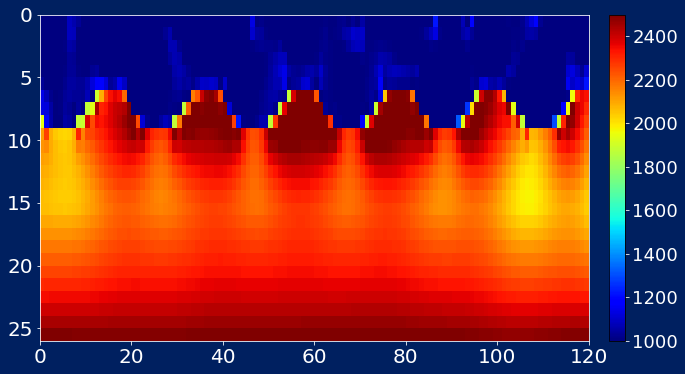

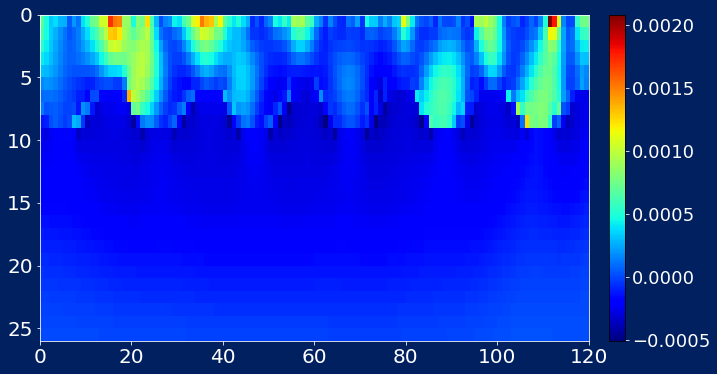

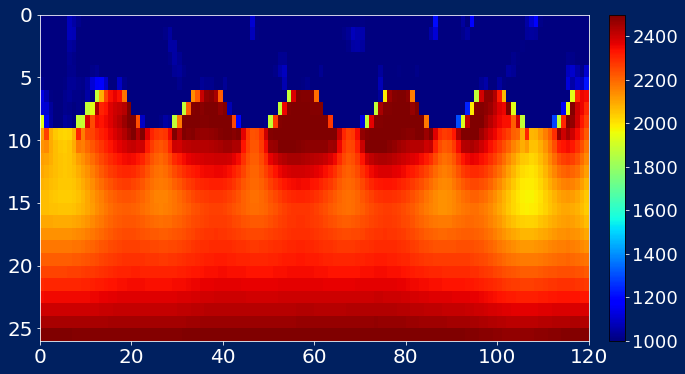

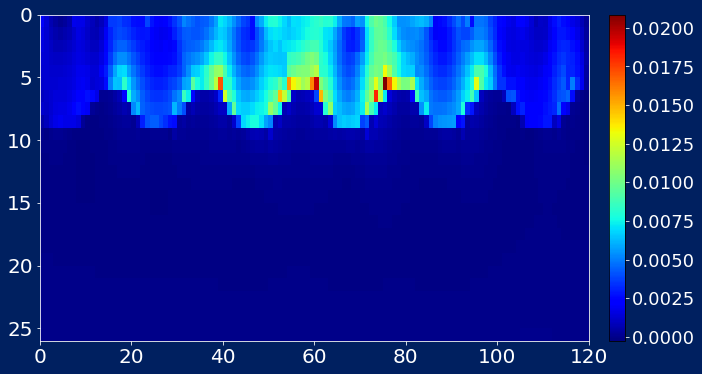

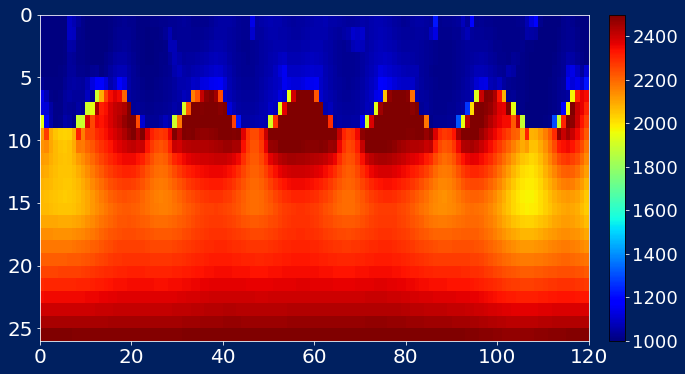

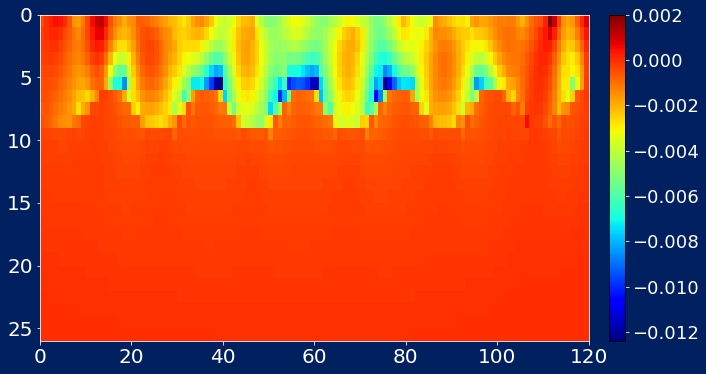

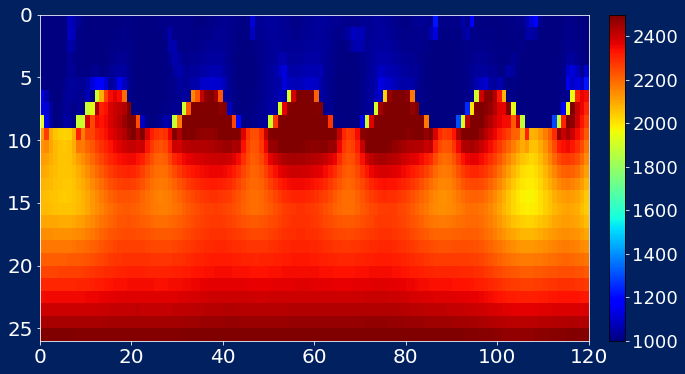

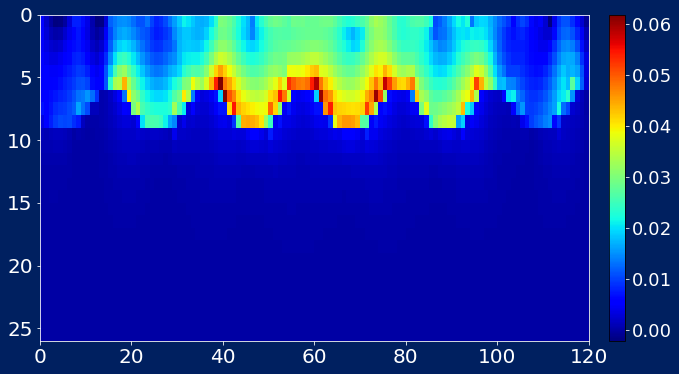

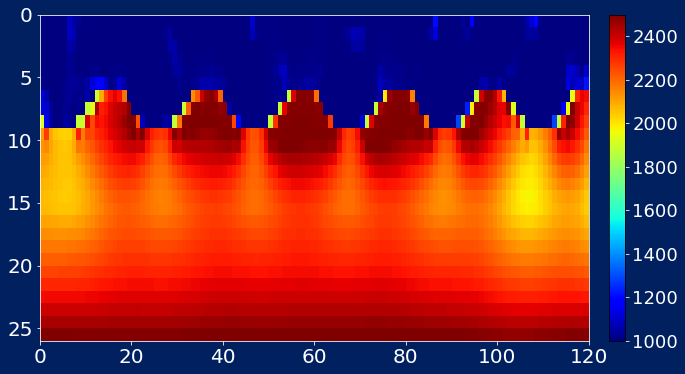

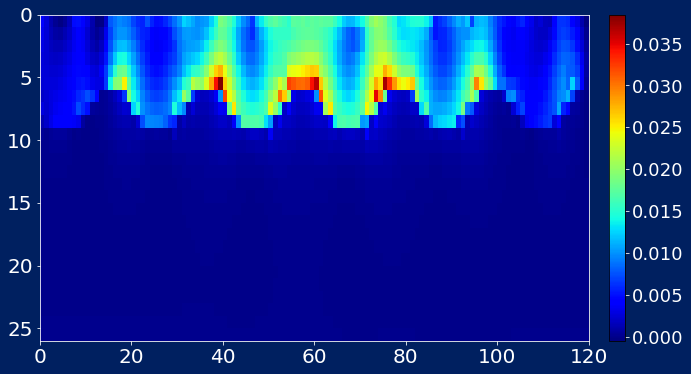

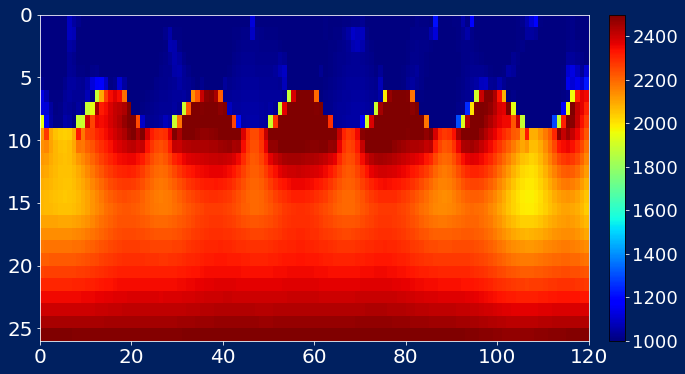

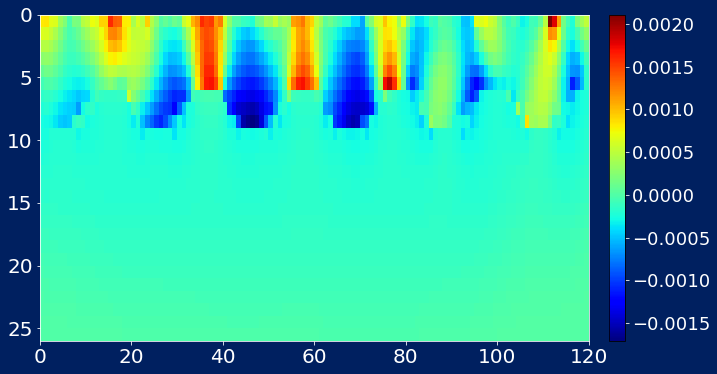

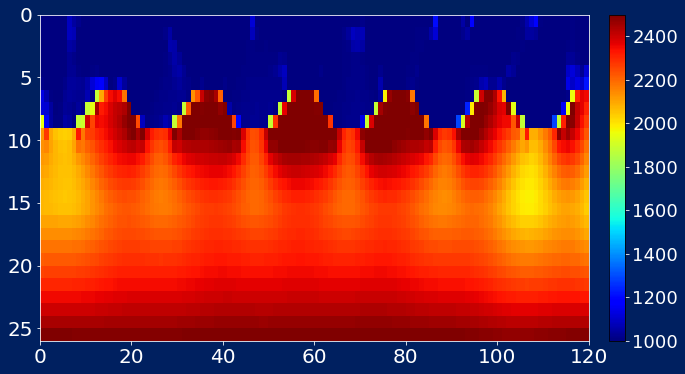

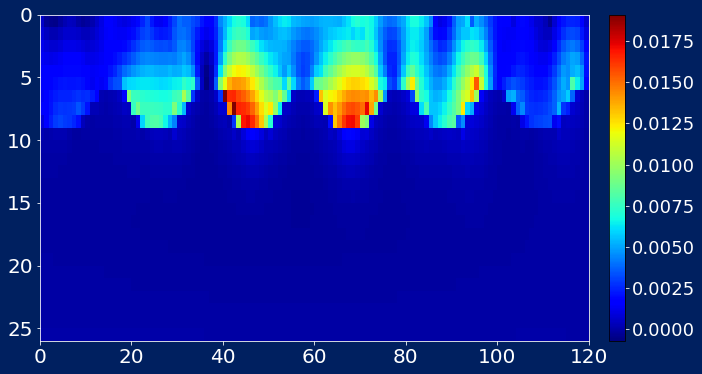

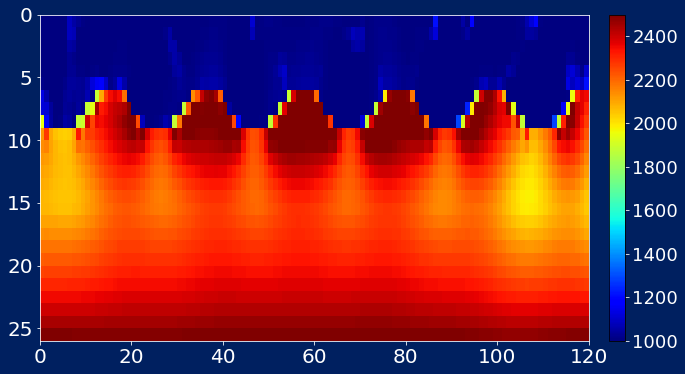

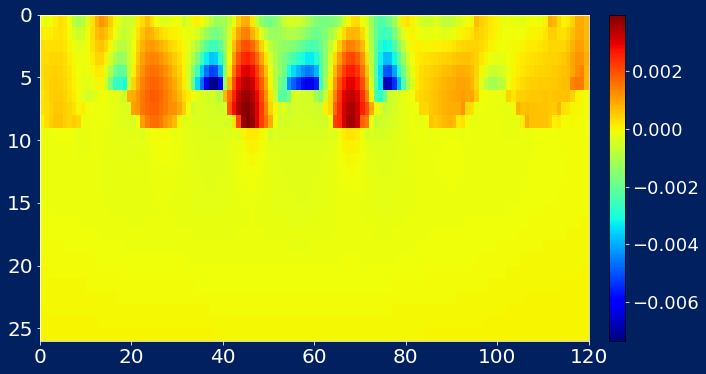

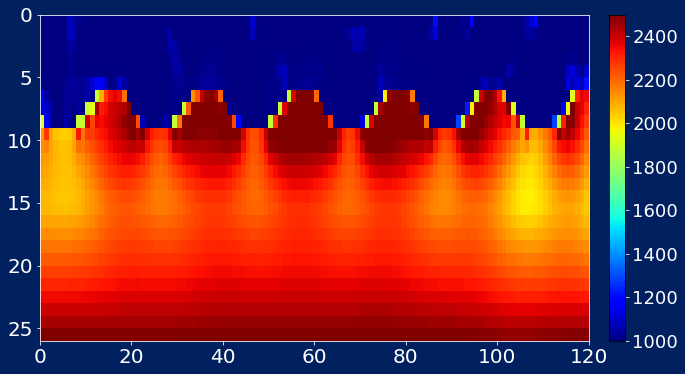

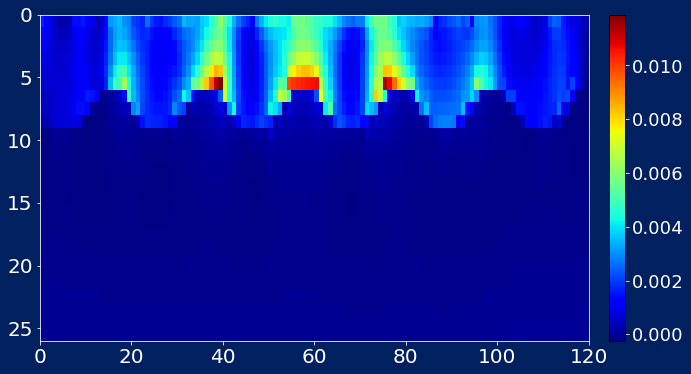

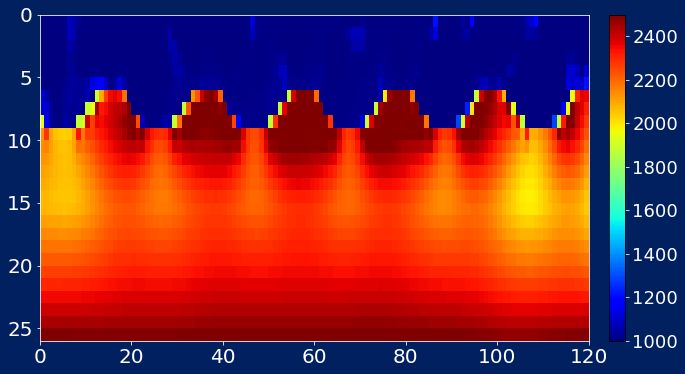

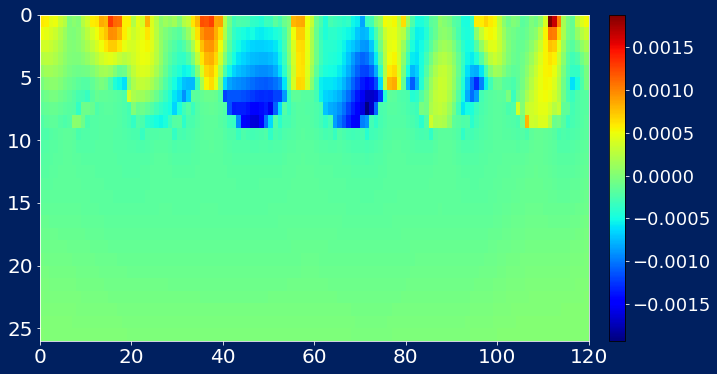

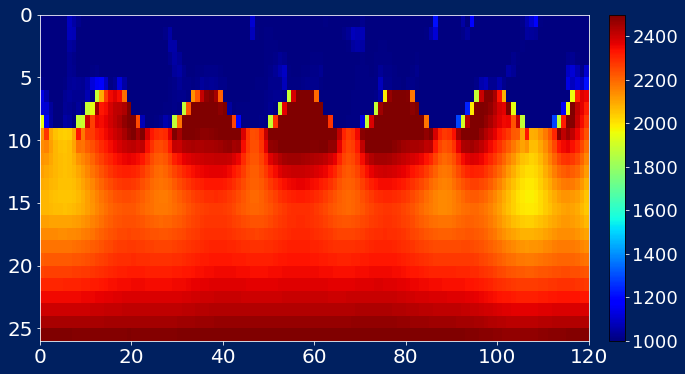

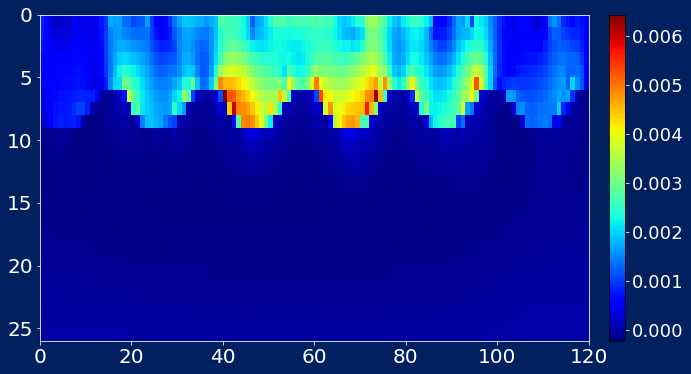

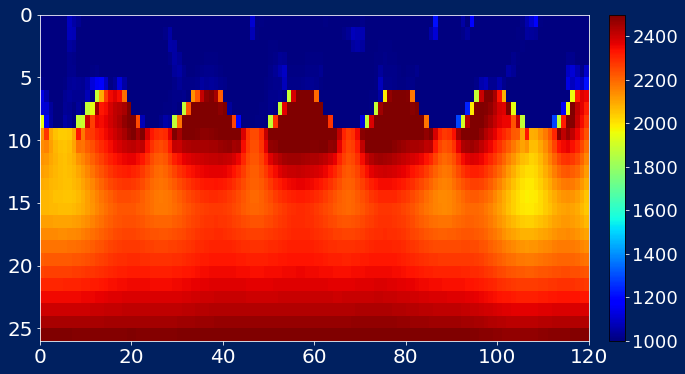

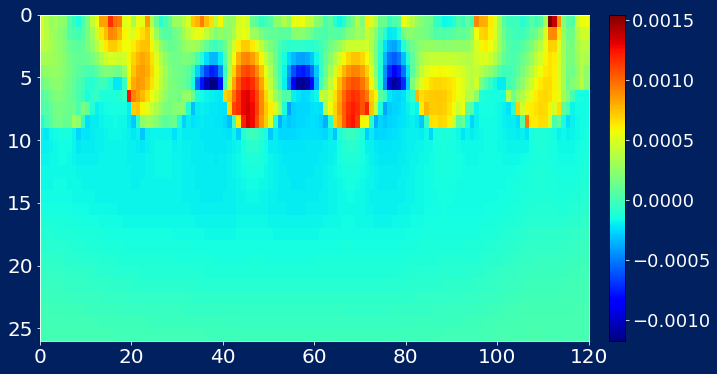

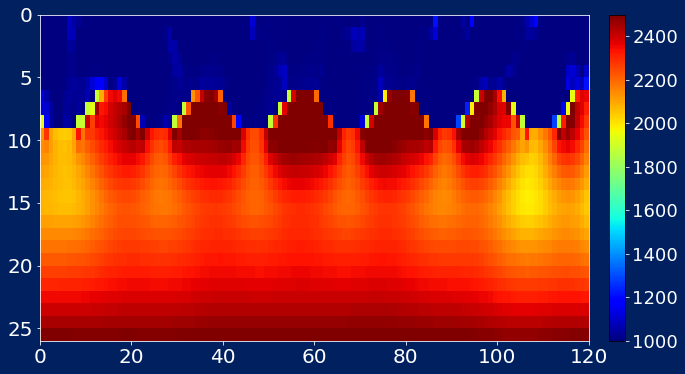

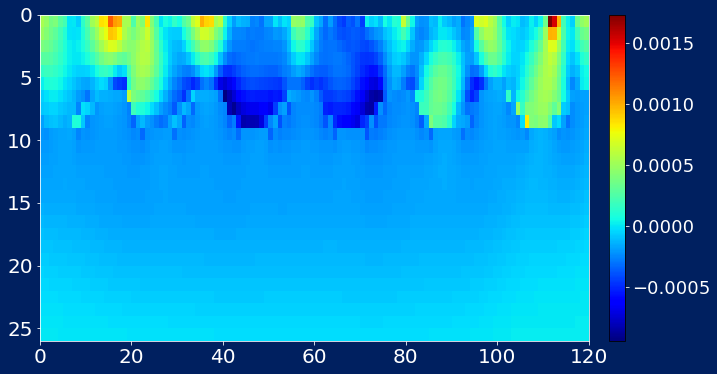

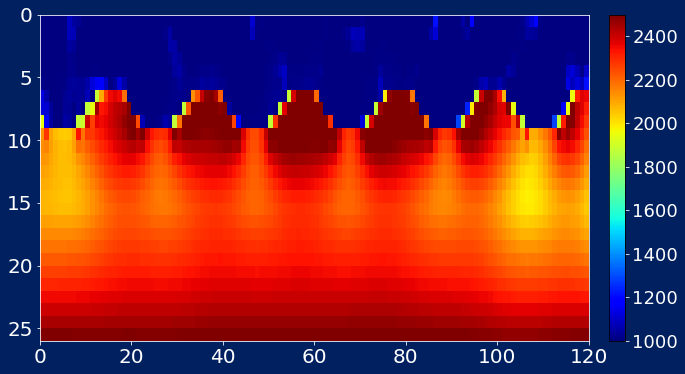

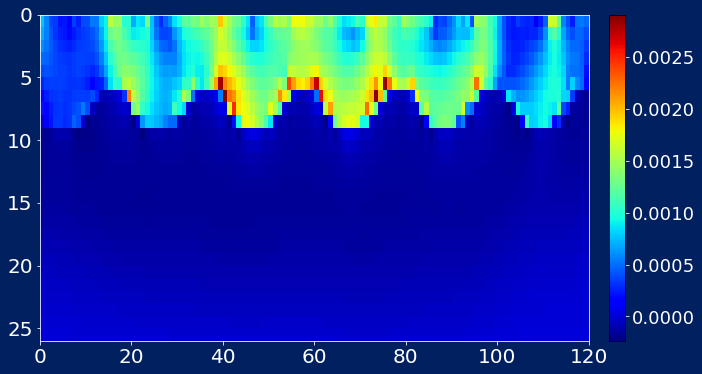

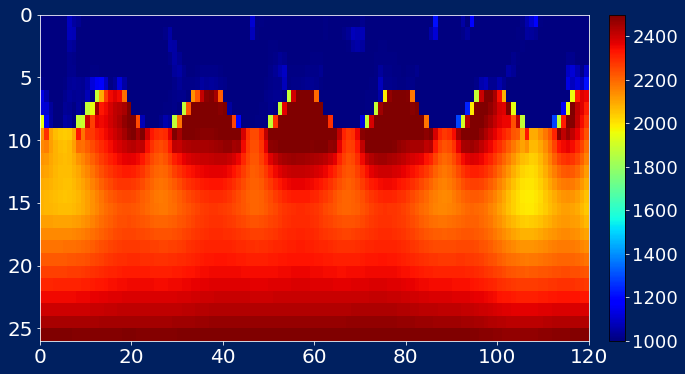

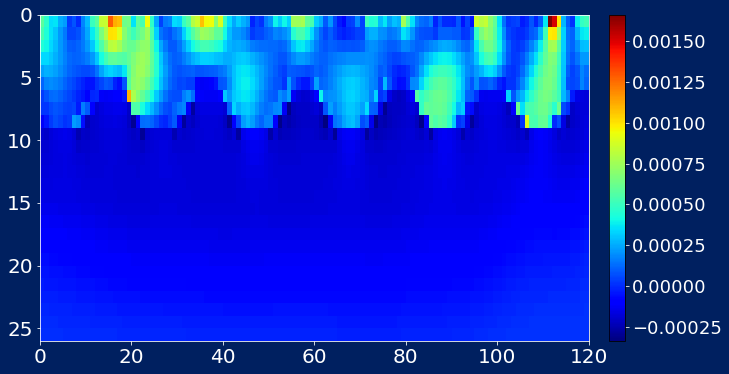

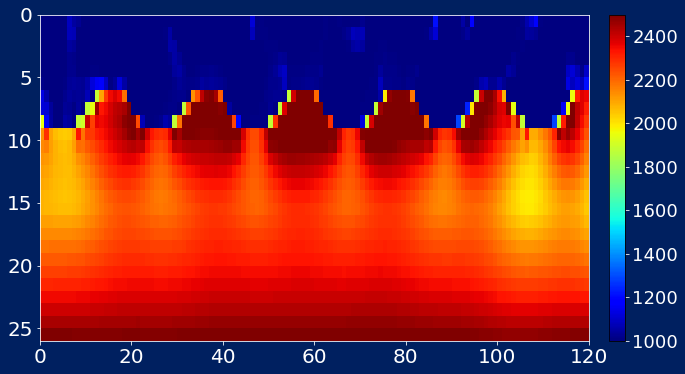

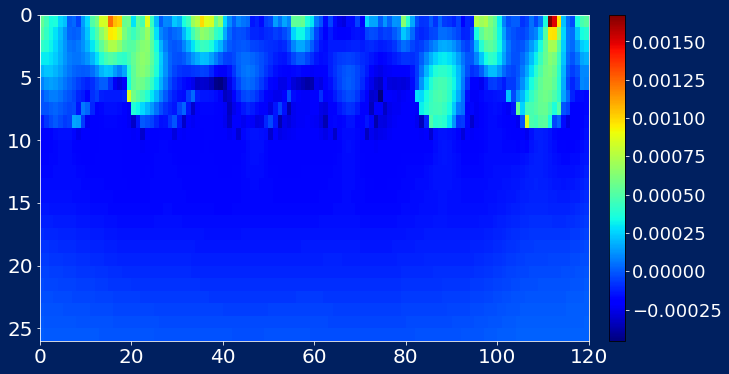

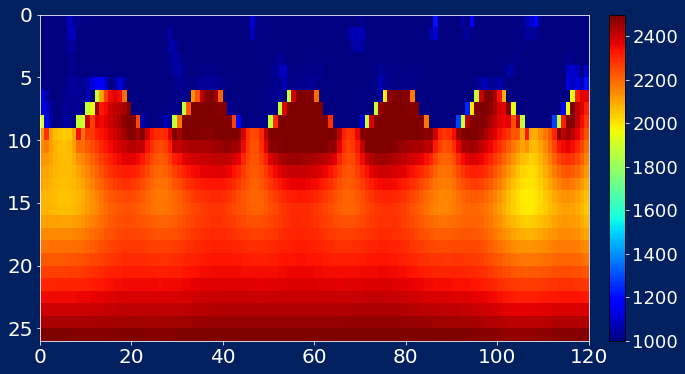

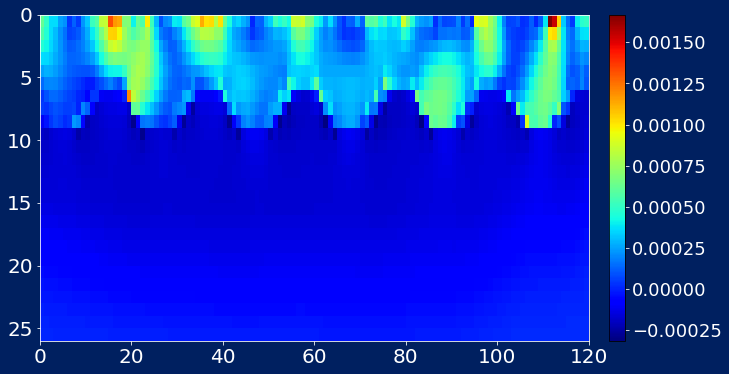

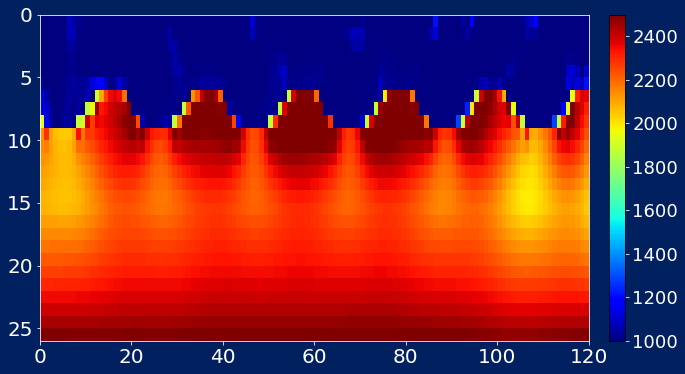

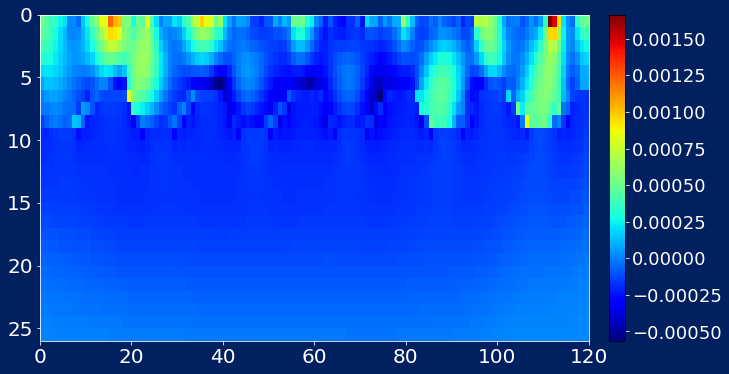

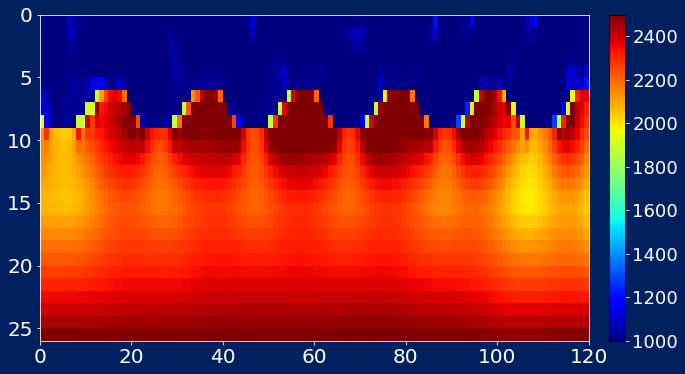

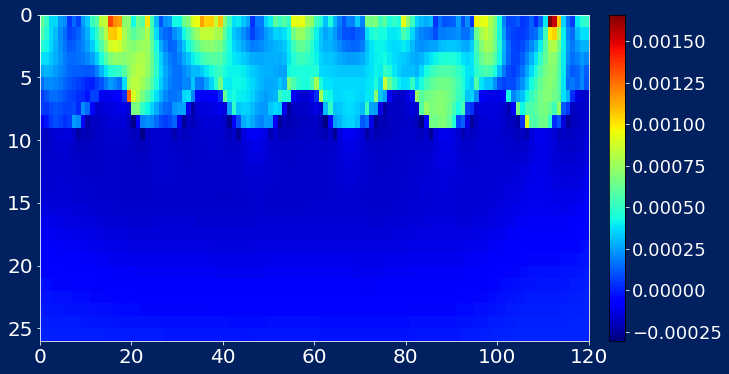

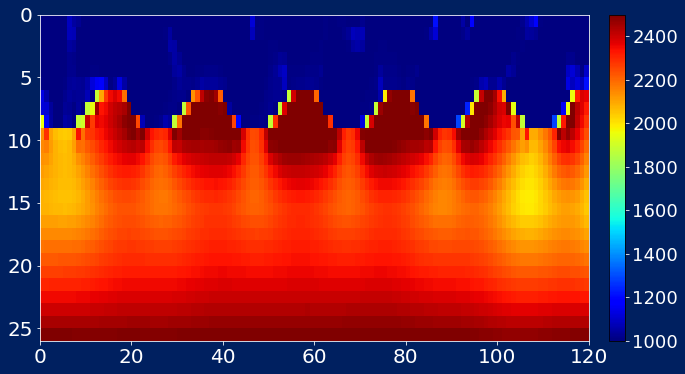

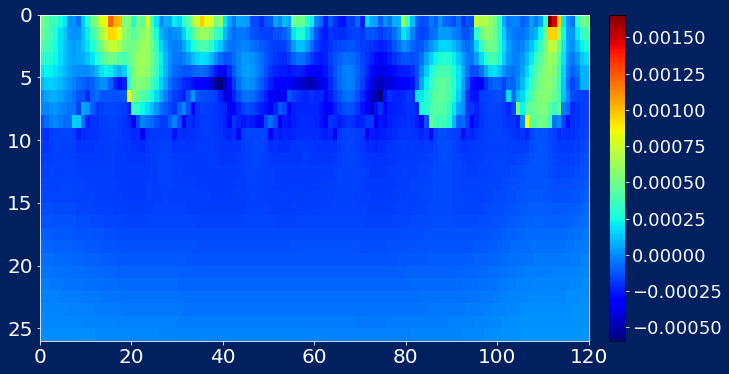

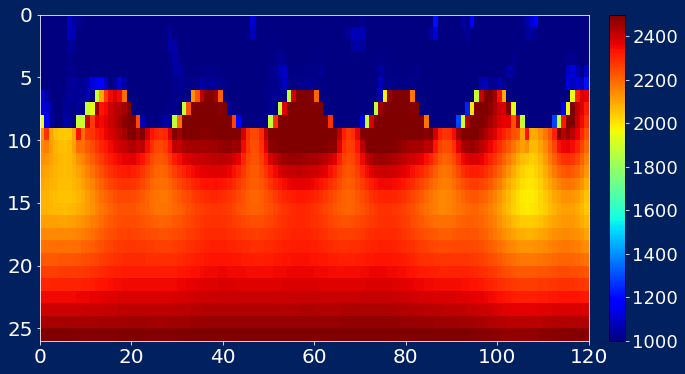

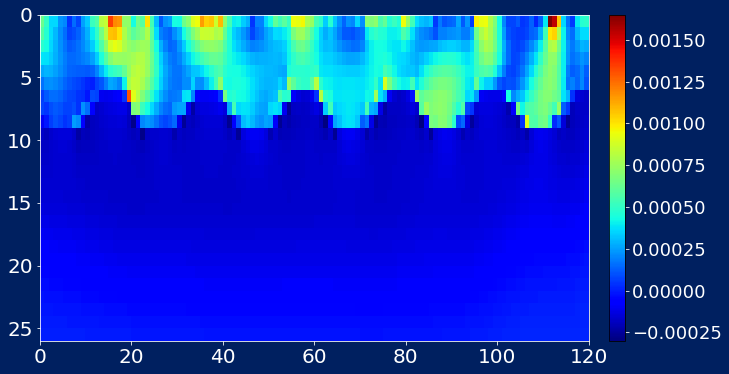

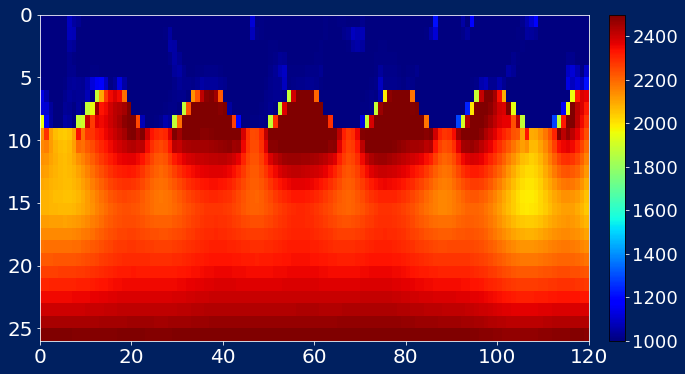

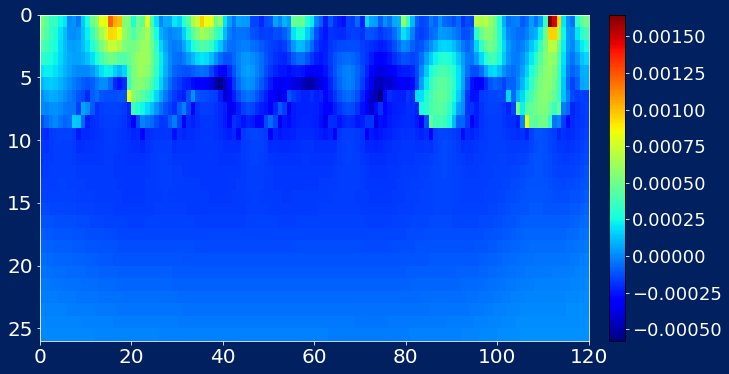

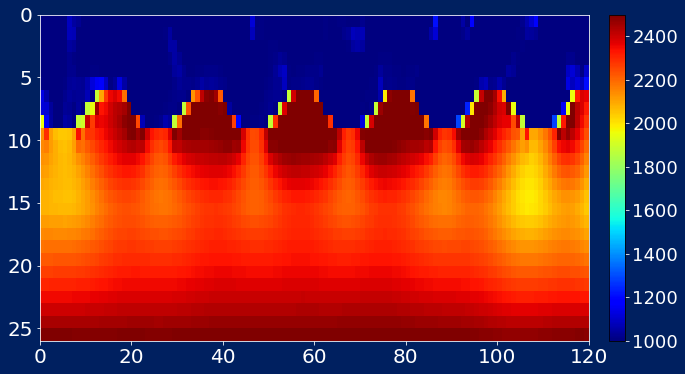

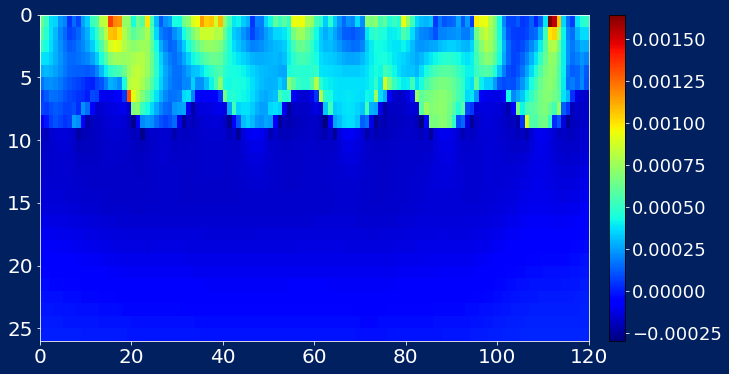

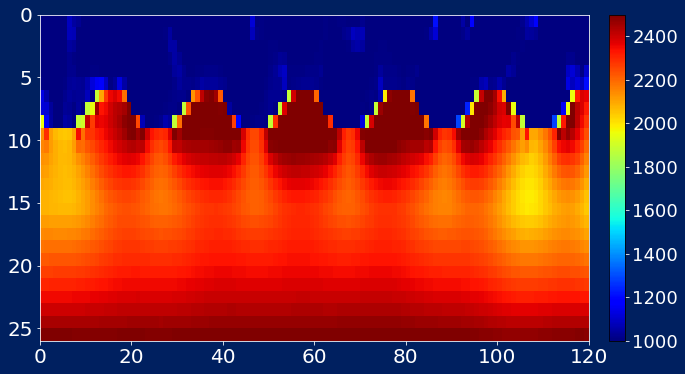

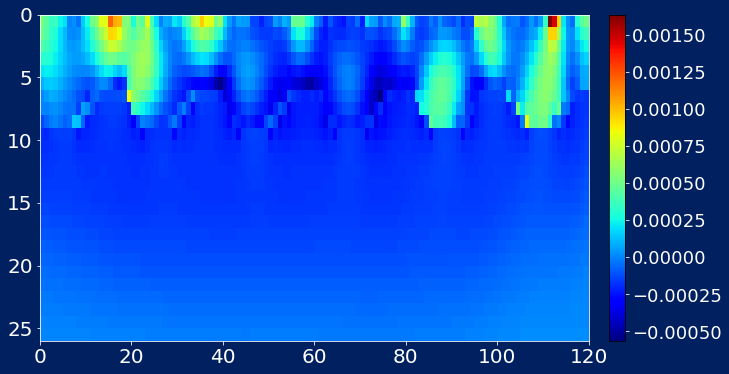

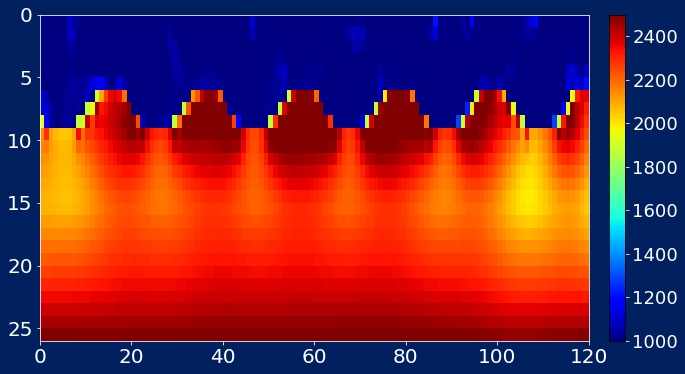

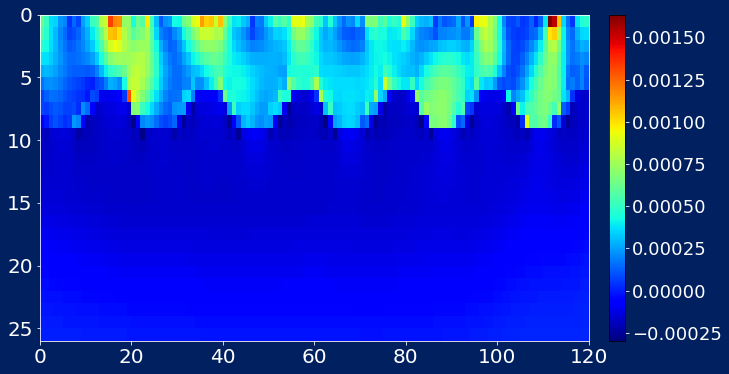

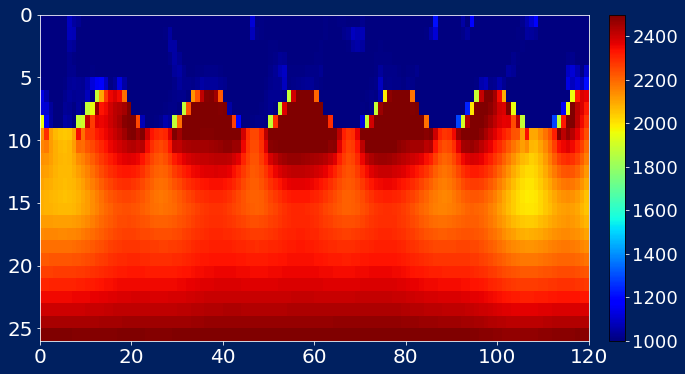

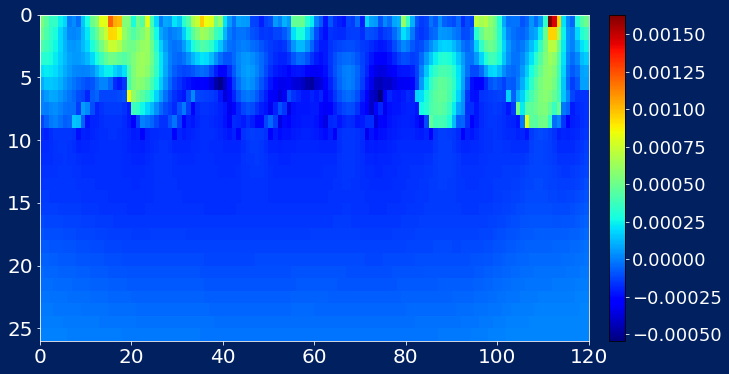

In [33]:
[lla,llb]=ca.size()
clgrad = torch.zeros((ns,lla,llb), device = 'cuda')
cmgrad = torch.zeros((ns,lla,llb), device = 'cuda')
vp = vp0
# vp.requires_grad=True
f1=1
iteration=100
res = torch.zeros((iteration), device='cuda')
for i in range(1,iteration):
    print(i)
    vp1 = pad(vp,nbc,pad_top)
    
    for gg in range(ns):        
        cl=torch.mul(vp1**2-2*vs1**2,den)
        cm=torch.mul((vs1**2),den)
        cl.requires_grad=True
        cm.requires_grad=True
        ca=cl + 2*cm
        den = den
        den1=den
        cm1=cm
        cl1 = cl * denm0
        cam = torch.zeros((nz+nbc+pad_top,nx+nbc+nbc), device='cuda')
        cam[pad_top-1,:] = 2 * cm[pad_top-1,:] - ca[pad_top-1,:]
        ca = ca + cam
        b=dtx*torch.reciprocal(den)
        b = b * denm2
        b1=b
        input_vector[6] = int(sx[gg])
        [seismo_u,seismo_w]=libtorch_staggerfd_cuda.forward(input_vector,temp,ca,cl1,cm,cm1,b,b1,s)
        loss = torch.sum((seismo_w-seismo_v_d[gg,:,:])**2)
        res[i] = res[i] + loss.data
        loss.backward()
        clgrad[gg,:,:] = cl.grad
        cmgrad[gg,:,:] = cm.grad
        cl.grad.zero_()
        cm.grad.zero_()
    print(res[i])
    if res[i] > res[i-1]:
        f1 = f1/2
    g_cl = torch.sum(clgrad[:,pad_top:-nbc,nbc:-nbc],0)
    g_cm = torch.sum(cmgrad[:,pad_top:-nbc,nbc:-nbc],0)
    dk_vp = 2*vp.data*g_cl.data
    alpha = 0.05*torch.sqrt(torch.sum(vp.data**2)/torch.sum(dk_vp.data**2))
    vp.data = vp.data - f1*alpha*dk_vp.data
    vp = torch.where(vp > vpmax, maxlinep, vp)
    vp = torch.where(vp < vpmin, minlinep, vp)
    vp = torch.where(vp/vs_RM < 1.3, vs_RM*1.3, vp)
    imagesc((vp).detach().cpu().numpy())
    imagesc((dk_vp).detach().cpu().numpy())

In [34]:
f1

0.0078125

In [69]:
cl=torch.mul(vp1**2-(2*vs1**2),den)
cm=torch.mul((vs1**2),den)

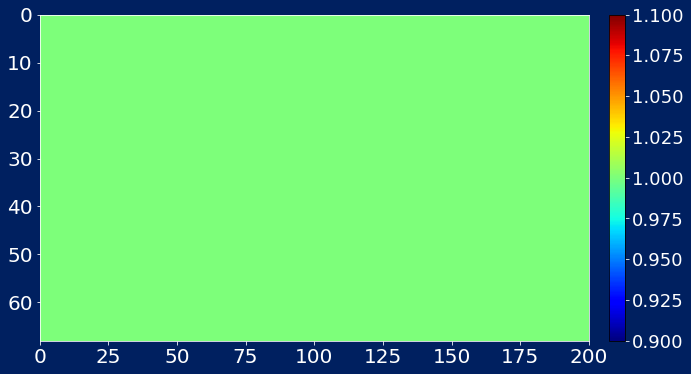

In [27]:
imagesc(vp.detach().cpu().numpy())

In [71]:
den

tensor([[1.0000000000e+00, 1.0000000000e+00, 1.0000000000e+00,  ...,
         1.0000000000e+00, 1.0000000000e+00, 1.0000000000e+00],
        [1.0737418240e+09, 1.0737418240e+09, 1.0737418240e+09,  ...,
         1.0737418240e+09, 1.0737418240e+09, 1.0737418240e+09],
        [1.0000000000e+00, 1.0000000000e+00, 1.0000000000e+00,  ...,
         1.0000000000e+00, 1.0000000000e+00, 1.0000000000e+00],
        ...,
        [1.0000000000e+00, 1.0000000000e+00, 1.0000000000e+00,  ...,
         1.0000000000e+00, 1.0000000000e+00, 1.0000000000e+00],
        [1.0000000000e+00, 1.0000000000e+00, 1.0000000000e+00,  ...,
         1.0000000000e+00, 1.0000000000e+00, 1.0000000000e+00],
        [1.0000000000e+00, 1.0000000000e+00, 1.0000000000e+00,  ...,
         1.0000000000e+00, 1.0000000000e+00, 1.0000000000e+00]],
       device='cuda:0')

In [69]:
dk_ca = torch.sum(cagrad,0)
dk_cm = torch.sum(cagrad,0)

In [72]:
dk_ca = torch.sum(cagrad,0)
dk_cm = torch.sum(cmgrad,0)
ca = ca + dk_ca
cm = cm + dk_cm

In [ ]:
cl = ca - 2*cm

AttributeError: 'Tensor' object has no attribute 'zero_grad'

In [40]:
loss = torch.sum(seismo_w-seismo_v_d[0,:,:])

In [41]:
loss.backward()

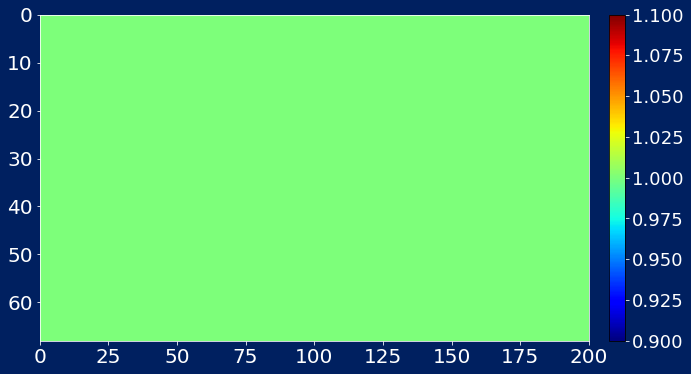

In [17]:
imagesc(den.detach().cpu().numpy())